# 1. 데이터셋 내려받기

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
train = tfds.load('tf_flowers', split='train[:80%]', as_supervised=True)
validation = tfds.load('tf_flowers', split='train[80%:90%]', as_supervised=True)
test = tfds.load('tf_flowers', split='train[90%:]', as_supervised=True)

In [3]:
len(train), len(validation), len(test)

(2936, 367, 367)

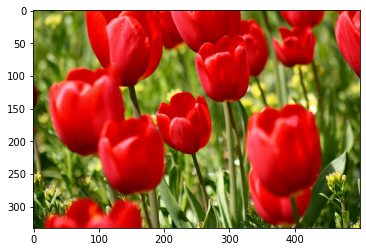

In [4]:
for i, (image, label) in enumerate(train.take(1)):
  plt.imshow(image)

# 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

In [5]:
IMG_SIZE = 160
BATCH_SIZE = 32

def formatting(image, label):
    image=tf.cast(image, tf.float32)
    image=(image/127.5)-1
    image=tf.image.resize(image, (IMG_SIZE,IMG_SIZE))
    return image, label

train_batches = train.map(formatting).batch(BATCH_SIZE)
validation_batches = validation.map(formatting).batch(BATCH_SIZE)
test_batches = test.map(formatting).batch(BATCH_SIZE)

In [6]:
for images, labels in train_batches.take(1):
    print(images.shape)
    print(labels.shape)

(32, 160, 160, 3)
(32,)


# 3. 모델 설계하기

In [7]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

input_layer = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output_layer = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(input_layer, output_layer)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 14,780,997
Trainable params: 66,309
Non-trainable params: 14,714,688
_________________________________________________________________


# 4. 모델 학습시키기

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

LEARNING_RATE = 0.001

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.utils import to_categorical

EPOCHS = 10

history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 19s 135ms/step - loss: 0.9871 - accuracy: 0.6594 - val_loss: 0.6684 - val_accuracy: 0.7657
Epoch 2/10
92/92 [==============================] - 7s 81ms/step - loss: 0.6208 - accuracy: 0.7895 - val_loss: 0.5687 - val_accuracy: 0.8011
Epoch 3/10
92/92 [==============================] - 8s 83ms/step - loss: 0.5280 - accuracy: 0.8202 - val_loss: 0.5275 - val_accuracy: 0.8147
Epoch 4/10
92/92 [==============================] - 8s 85ms/step - loss: 0.4740 - accuracy: 0.8379 - val_loss: 0.5050 - val_accuracy: 0.8256
Epoch 5/10
92/92 [==============================] - 8s 87ms/step - loss: 0.4353 - accuracy: 0.8518 - val_loss: 0.4891 - val_accuracy: 0.8311
Epoch 6/10
92/92 [==============================] - 8s 85ms/step - loss: 0.4042 - accuracy: 0.8617 - val_loss: 0.4785 - val_accuracy: 0.8311
Epoch 7/10
92/92 [==============================] - 8s 83ms/step - loss: 0.3779 - accuracy: 0.8753 - val_loss: 0.4722 - val_accuracy: 0.8311
Epoch 8/10


# 5. 모델 성능 평가하기

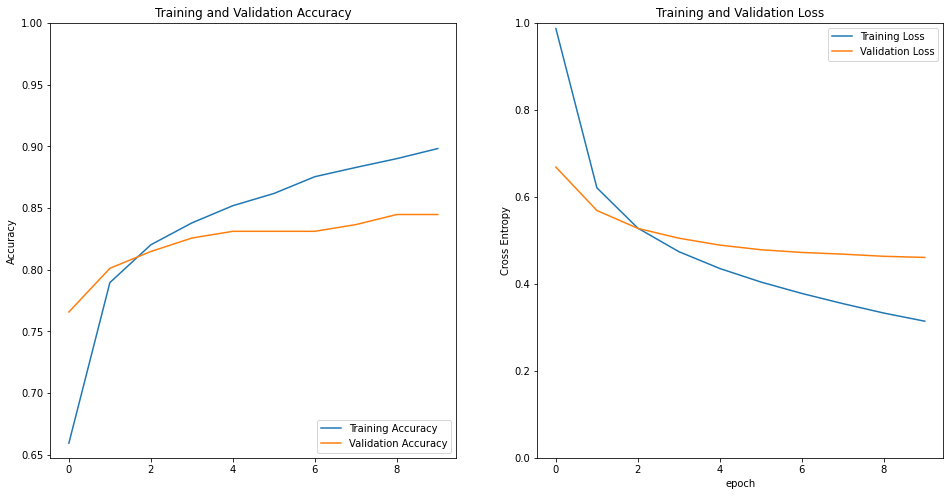

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#val이 아슬아슬하다

In [13]:
predict = model.predict(test_batches)

array([[3.49433650e-03, 1.06552811e-02, 9.01405454e-01, 1.23513043e-02,
        7.20936656e-02],
       [9.99859571e-01, 1.35454480e-04, 2.06114549e-07, 1.57267402e-06,
        3.18931370e-06],
       [6.83510363e-01, 1.21760674e-01, 8.32078420e-03, 1.79237336e-01,
        7.17091188e-03],
       ...,
       [1.43279403e-01, 9.68208723e-03, 6.32148802e-01, 1.29664615e-01,
        8.52250606e-02],
       [9.83138680e-01, 1.57459099e-02, 1.73010849e-04, 9.04802873e-04,
        3.76656535e-05],
       [2.28276156e-04, 2.49360153e-03, 3.40499505e-02, 9.60733593e-01,
        2.49458151e-03]], dtype=float32)

In [14]:
model.evaluate(test_batches)

12/12 [==============================] - 1s 67ms/step - loss: 0.4097 - accuracy: 0.8529


[0.40969690680503845, 0.8528610467910767]

# 6. 모델 활용하기

In [ ]:
URL = '~/data/roses/'
